# Identify the candidate blooming bacteria

The goal of this notebook is to identify candidate bacteria which bloom under shipping conditions. We identified cadnidates in two parts: first, we looked for bacteria which grew at room temperature in storage studies. We also looked at shipped American Gut samples and compared them to fresh frozen fecal samples. We used the combined technique because the storage studies were limited by size, while the comparison between studies is noisy.

Briefly, this process will involve the following steps:

1. Load the datasets (Mayo and Se-Jin storage studies and AG, PGP, UK-Twins and Whole grain feces)
2. Calculate the fold change per sOTU in the storage studies
3. Calculate the fold change in AG compared to fresh frozen studies (PGP, UK-Twins and Whole grain feces)
4. Identify candidate blooming bacteria by combining the fold changes in 2,3
5. Plot the scatter of the fold change per sOTU with highlighting the candidate blooming bacteria
6. Plot taxonomy plots before and after bloom filtering

Let's start by loading the necessary python functions. 

In [44]:
import matplotlib as mpl
mpl.use('Agg')

# load modules used in the analysis
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import skbio
from skbio.stats.composition import ancom, closure

# plots inside the notebook
%matplotlib notebook

# set the random seed
np.random.seed(2016)

/Users/jdebelius/miniconda2/envs/bloom/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Loading all experimental data

We'll write a quick function to load the data. We'll load the biom table (`biom_fp`). We'll load the specified metadata columns (`meta_fp` and `keep_columns`). Then, we'll filter the data to include only samples with at least 1000 counts/sample (`depth`) and that fit the filtering criteria (`filters`). Finally, we'll add information about the study and preservation method to make later analysis easier.

In [62]:
def load_studies(biom_fp, meta_fp, name, preservation, keep_columns=None, 
                 filters={}, depth=1000):
    """Loads the studies more easily"""
    # Loads the mapping file
    if keep_columns == None:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str)
    else:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str, usecols=keep_columns)
    meta.set_index('#SampleID', inplace=True)
    
    # Loads the biom table
    sotu = biom.load_table(biom_fp)

    # We'll first filter the table by sequencing depth
    sotu = sotu.filter(lambda val, id_, md: val.sum() > depth, axis='sample')
    meta = meta.loc[sotu.ids(axis='sample')]
    
    # Filters the samples
    def filter_meta(x):
        return np.all([x[k] == v for k, v in filters.items()])
    
    meta_f = meta.loc[meta.apply(filter_meta, axis=1)].copy()
    meta_f['STUDY'] = name
    meta_f['PRESERVATION'] = preservation
    sotu_f = sotu.filter(meta_f.index)
    
    return meta_f, sotu_f

## Song fecal stability study

The Song fecal stability study [[1](#1)] compares the stability of human and dog fecal samples under a variety of storage conditions.

We will only use samples with no preservative stored at ambient temperature for 7, 14 and 28 days (compared to samples sequenced at day 0).

In [63]:
song_meta, song_sotu = load_studies(
    biom_fp = '../data/storage.sejin.clean.withtax.biom',
    meta_fp = '../data/map.storage.sejin.txt',
    name='SONG',
    preservation='STORAGE',
    keep_columns=['#SampleID', 'preservative', 'temperature', 'temp2', 'species', 
                  'time_numeric', 'subject'],
    filters={'preservative': 'None',
             'temperature': 'amb',
             'species': 'human'},
    )

The sample is filtered to only include perservative-free samples stored at room temperature. These include samples collected at day 0 and immediately sequenced, which we use as a reference. We will only use samples with at least 1000 sequences.

## Mayo fecal stability study

The Mayo fecal stability study [[2](#2)] compares the effect of different storage conditions on human fecal samples. Samples were stored at room temperature with or without perservatives. We'll only look at samples without perservative.

In [64]:
mayo_meta, mayo_sotu = load_studies(
    biom_fp = '../data/mayo.new.min10.clean.withtax.biom',
    meta_fp = '../data/map.mayo1.txt',
    name='MAYO_STORAGE',
    preservation='STORAGE',
    filters={'TREATMENT': 'No Additive'},
    )

## American Gut

The [American Gut Project](<http://www.americangut.org>) is a cross sectional study. Samples were shipped through local post without perservatives. We will use only fecal samples with at least 1000 sequences per sample.

In [65]:
agp_meta, agp_sotu = load_studies(biom_fp='../data/ag-6-2016.clean.min100.withtax.biom',
                                  meta_fp='../data/map.ag-6-2016.txt',
                                  name='AGP',
                                  preservation='NONE',
                                  keep_columns=['BODY_HABITAT', '#SampleID'],
                                  filters={'BODY_HABITAT': 'UBERON:feces'}
                                  )

## UK twins study

We'll use data from Goodrich et al [[3](#3)], a fresh frozen study comparing the heritability of the microbiome in monozygotic and dizygotic twins.

In [66]:
twin_meta, twin_sotu = load_studies(biom_fp='../data/twins2.clean.min10.withtax.biom',
                                meta_fp='../data/map.twins2.txt',
                                name='UK_TWINS',
                                preservation='FRESH_FROZEN',
                                keep_columns=['env_matter', '#SampleID'],
                                filters={'env_matter': 'ENVO:feces'}
                                )

## PGP

(unpublished), Qiita study ID [1189](<https://qiita.ucsd.edu/study/description/1189>)

Samples were collected from participants in the Personal Genome Project and fresh frozen. The study has not yet been published, but data is avaliable in [Qiita study 1189](<https://qiita.ucsd.edu/study/description/1189>). The study contains fecal, oral and skin samples. We'll use only the fecal samples.


In [51]:
pgp_meta, pgp_sotu = load_studies(biom_fp='../data/pgp.baylor.clean.withtax.biom',
                                  meta_fp='../data/map.pgp.jwd.txt',
                                  name='PGP',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['#SampleID', 'body_product'],
                                  filters={'body_product': 'UBERON:feces'}
                                  )

## Ercolini whole grain feces

This study [[4](#4)] contains fecal samples from 80 healthy overweight/obese subjects, part of which undergoing whole grain wheat dietery intervention.

In [52]:
erc_meta, erc_sotu = load_studies(biom_fp='../data/ercolini.feces.clean.withtax.biom',
                                  meta_fp='../data/map.ercolini.txt',
                                  name='ERC',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['env_matter', '#SampleID'],
                                  filters={'env_matter': 'ENVO:feces'}
                                  )

# Analysis

## Calculate growth for bacteria in storage studies
For each sOTU, calculate the mean fold change over all individuals, using a minimal read cutoff of 5 reads/sample to reduce effect of discretization and multinomial sampling of low frequency sOTUs.

Let's start by defining the function we'll use to calculate these fold differences. We'll take a map and subOTU table for a storage study. We assume that this study includes multiple samples from the same individual (designated by the `subject` column). We can compare the difference between timepoints (identied as the values of `time0` and `time1` and found in the `time_col`). Additional filters to select the sames, such as the perservative or storage temperature can be specified as well, using `filters`. The minimum sequencing depth for a sample to be considered is set as `seq_depth`, while the minimum number of counts for an OTU to be compared is `min_count`.

The function will calculate the mean fold change in sOTUs of interest between the two time points for all OTUs which have at least hte minimum number of counts either before or after storage.

In [53]:
def test_stability(map_, otu_, time_col='time_numeric', time0='1', time1='2', 
                   subject_col='subject', mincount=5, seq_depth=2500, filters={}):
    """Calculates the fold change in a sub OTU between timepoints
    
    Parameters
    ----------
    map_ : DataFrame
        The mapping file for the study. Must contain the columns
    """
    # Sets up a filter for the mapping file to get the appropriate data.
    def stability_filter(x):
        return ((x['seq_depth'] > seq_depth) & 
                (x[time_col] in {time0, time1}) &
                (np.all([x[c] == v for c, v in filters.items()]))
                )
    
    # Filters the mapping file and otu table
    map_ = map_.loc[map_.apply(stability_filter, axis=1)].copy()
    otu_ = otu_.filter(map_.index, inplace=False)
    otu_ = otu_.filter(lambda val, id_, md: (val.sum() > 0), axis='observation')
    
    otu_ids = otu_.ids('observation')
    ratios = []
    subjects = []
    # Groups by subject and iterates through the comparison
    for hsi, sub_map in map_.groupby(subject_col):
        # Gets the list of samples at each time point
        id0 = set(sub_map.index[sub_map[time_col] == time0])
        id1 = set(sub_map.index[sub_map[time_col] == time1])
        
        # If there aren't samples for each timepoint, continue
        if ((len(id0) == 0) or (len(id1) == 0)):
            continue
        
        # Gets the OTU data
        sotus0 = otu_.filter(id0, inplace=False).sum(axis='observation') / len(id0)
        sotus1 = otu_.filter(id1, inplace=False).sum(axis='observation') / len(id1)

        low = (sotus0 < mincount) & (sotus1 < mincount)

        sotus0[sotus0 < mincount] = mincount
        sotus1[sotus1 < mincount] = mincount

        ratio = sotus1 / sotus0
        ratio[low] = np.nan
        ratios.append(ratio)
        subjects.append(hsi)
    
    # Gets the list of ratios exlcuding any otu which doesnt meet the filtering criteria
    ratios = pd.DataFrame(np.vstack(ratios), index=subjects, columns=otu_ids)
    ratios.dropna(1, inplace=True, how='all')

    # Calculate the mean fold change and the log fold change
    fc = pd.Series(np.nanmean(ratios, 0), index=ratios.columns)
    
    return fc

We'll also generate a pretty histogram plot showing the comparison. This will take the fold change values and return a maplotlib axis with a plot. 

In [54]:
def plot_logfoldchange_histogram(foldchange, fig=None, ax=None):
    """Makes a pretty histogram of the fold change"""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.axes()
    # Constant limits and bins facilitate comparisons
    sn.distplot(np.log2(foldchange.dropna()), ax=ax, bins=np.linspace(-12, 12, 120))
    ax.set_xlim([-12, 12])
    ax.set_ylim([0, 1])
    # Sets up axis labels
    ax.set_ylabel('Number of OTUs', size=24)
    ax.set_xlabel('log$_{2}$(fold change)', size=24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    
    return fig

Let's look at the difference between day 0 and day 4 in samples from the Mayo Stability study.

<IPython.core.display.Javascript object>


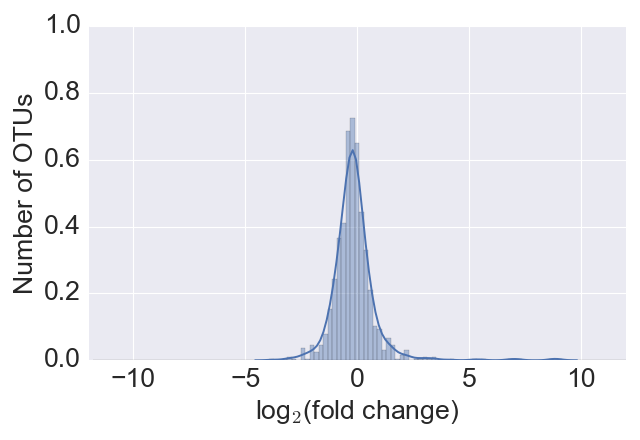

In [55]:
# mayo 4 days
mayo4_fc = test_stability(mayo_meta, mayo_sotu, time_col='SAMPLE_VISIT', time0='Day 0', time1='Day 4',
                          subject_col='HOST_SUBJECT_ID')
mayo4_fig = plot_logfoldchange_histogram(mayo4_fc)

mayo4_fig.savefig('../results/fig1-hist-mayo-4-0.pdf')

Let's also look at the change between day 0 and day 1 in the same study.

<IPython.core.display.Javascript object>


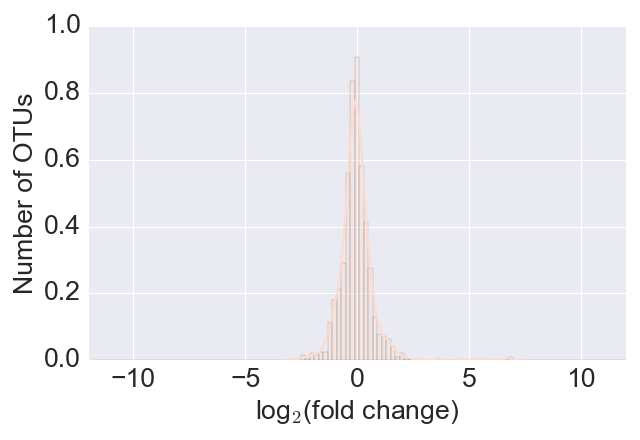

In [61]:
# mayo 1 days
mayo1_fc = test_stability(mayo_meta, mayo_sotu, time_col='SAMPLE_VISIT', time0='Day 0', time1='Day 1',
                          subject_col='HOST_SUBJECT_ID')
mayo1_fig = plot_logfoldchange_histogram(mayo1_fc)
mayo1_fig.savefig('../results/fig1-hist-mayo-1-0.pdf')

<IPython.core.display.Javascript object>


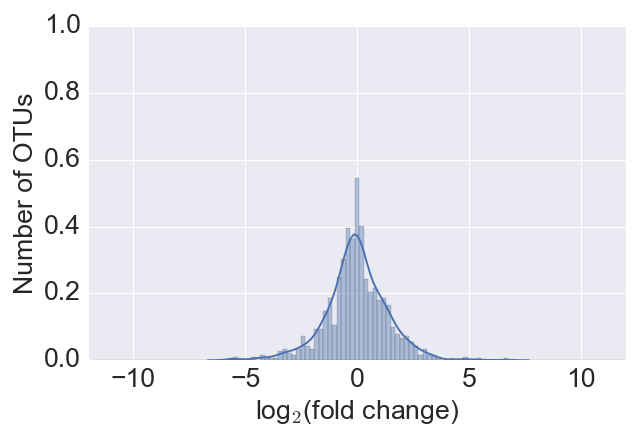

In [101]:
# se jin 1 week
sj7fc = test_stability(song_meta, song_sotu, time0='1', time1='2', filters={'temp2': 'amb'})
sj7fc_fig = plot_logfoldchange_histogram(sj7fc)
sj7fc_fig.savefig('../results/fig1-hist-sejin-7-0.pdf')

In [69]:
plt.savefig('../results/fig1-hist-sejin-7-0.pdf')

<IPython.core.display.Javascript object>


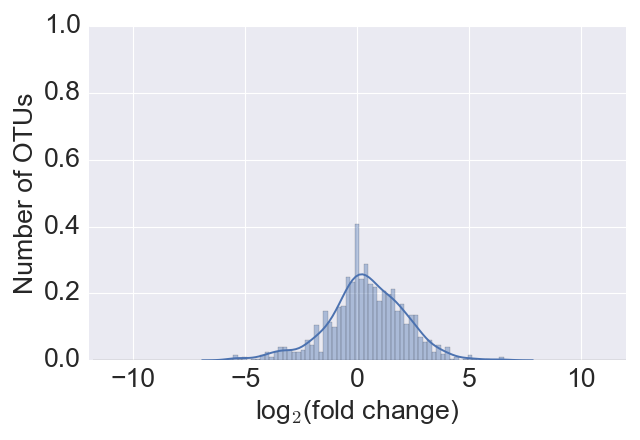

In [102]:
# se jin 2 weeks
sj14fc = test_stability(song_meta, song_sotu, time0='1', time1='3', filters={'temp2': 'amb'})
sj14fc_fig = plot_logfoldchange_histogram(sj14fc)
sj14fc_fig.savefig('../results/fig1-hist-sejin-14-0.pdf')

<IPython.core.display.Javascript object>


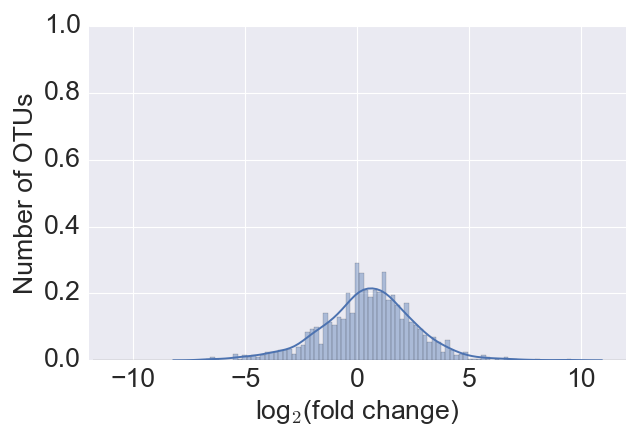

In [103]:
# se jin 4 weeks
sj28fc = test_stability(song_meta, song_sotu, time0='1', time1='4', filters={'temp2': 'amb'})
sj28fc_fig = plot_logfoldchange_histogram(sj28fc)
sj28fc_fig.savefig('../results/fig1-hist-sejin-28-0.pdf')

## differential expression
We'll next look at how American Gut, the shipped study, looks in comparison to the fresh frozen studies.

So, we'll join all the cross sectional studies together and find sOTUs which differ significantly.
Join all studies together and find sOTUs sginificantly higher/lower in AG

In [129]:
# Combines the metadata
fec_meta = pd.concat([pgp_meta[['STUDY', 'PRESERVATION']], 
                      twin_meta[['STUDY', 'PRESERVATION']], 
                      agp_meta[['STUDY', 'PRESERVATION']], 
                      erc_meta[['STUDY', 'PRESERVATION']]])

# Combines the sOTU tables
fec_sotu = pgp_sotu.merge(twins_sotu).merge(agp_sotu).merge(erc_sotu)

# ------- REMOVE THESE CELLS --------

In [ ]:
keep_ids = np.hstack(
    [np.random.choice(fec_meta.loc[fec_meta['STUDY'] == study].index, 25, replace=False)
     for study in fec_meta['STUDY'].unique()]
    )
fec_meta = fec_meta.loc[keep_ids]


In [42]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
            .. versionadded:: 1.7.0
    
    Parameters
    -----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if a was np.arange(n)
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry in a.
        If not given the sample assumes a uniform distribution over all
        entries in a.
    
    Returns
    --------
    samples : 1-D ndarray, s

# -------------------------------------------

We'll filter out low abundance OTUs, with fewer than 50 counts total across all four studies.

In [140]:
fec_sotu = fec_sotu.filter(lambda val, id_, md: val.sum() > 50, axis='observation', inplace=False)

We'll use ANCOM [[5](#5)] to analyze the differential abundance between the fresh frozen and unpreserved studies. We'll need to convert the biom table to a dataframe. ANCOM calcuates a significant difference in the ratio abundance between sOTUs, which accounts for compositionality in the data.

Please note the ANCOM results take a long time to run, and as a result, we have chosen to save the results as a binary file, which can be found in the results folder.

In [141]:
fec_close = pd.DataFrame(closure(fec_sotu.matrix_data.toarray() + 1).T,
                         index=fec_sotu.ids('sample'),
                         columns=fec_sotu.ids('observation'))

In [ ]:
%%time
ancom_stats, features = ancom(fec_close, fec_meta['PRESERVATION'], 
                              multiple_comparisons_correction='holm-bonferroni')

In [ ]:
with open('../results/sults/ancom_foldchange.p', 'wb') as f_:
    pickle.dump(f_, [ancom_stats, features])

## Calculate the fold change of american gut compared to all other experiments
For each sOTU, comapre the mean in all AG samples to the mean of all samples in a fresh-frozen experiment.

Note that since samples are not paired, we can just compare the means.

Comparison is calculated separately between AG and each fresh-frozen study (PGP, UK-Twins and Whole grain feces)

In [ ]:
def get2expfc(exp1,exp2,minreads=1):
    """Calculates the fold change betwen the two datasets
    """
    outfc={}
    numnotfound=0
    
    # copy experiments so we don't change their data
    exp1=hs.copyexp(exp1)
    exp2=hs.copyexp(exp2)
    # iterate over all sequences in exp1
    for cseq in exp1.seqs:
        dat1=exp1.data[exp1.seqdict[cseq]]
        # if below minreads in exp1 - convert to minreads
        dat1[dat1<minreads]=minreads
        # if not present in exp2, convert it to minreads
        if cseq not in exp2.seqdict:
            numnotfound+=1
            dat2=np.ones(len(exp2.samples))*minreads
        else:
            dat2=exp2.data[exp2.seqdict[cseq]]
        # if below minreads in exp2 - convert to minreads
        dat2[dat2<minreads]=minreads
        # calculate the mean ratio
        fc=np.mean(dat1)/np.mean(dat2)
        outfc[cseq]=fc

    print('%d sequences not found' % numnotfound)
    return outfc

In [ ]:
# fold change AG to PGP
fcpgp=get2expfc(agf,pgpf)

In [ ]:
# fold change AG to UK-Twins
fctwins=get2expfc(agf,twinsf)

In [ ]:
# fold change AG to Whole grains feces
fcerc=get2expfc(agf,ercf)

# find the blooming bacteria list
intersect the ag-vs-others and the storage studies fold changes:

Iterate over all sOTUs which are significantly different between AG and all fresh-frozen samples.

For each such sOTU, we calculate two values:
1. The maximal growth potential (maximum over all storage studies and days)
2. The minimal ratio between AG to each fresh-frozen sample. The minimum is taken in order to reduce the effect of study-study differences (since a blooming bacteria is expected to be higher in AG compared to all fresh-frozen studies)

Candidate blooming bacteria are defined as sOTUs that have either:
- At least two fold difference in both (1) and (2), or that are not

OR
- At least two fold difference in (2) and are not present in (1) (since storage studies have a small set of individuals, there may be blooming bacteria that by chance were not present in the storage study samples)

OR
- At least 50 fold change in (1), so we know they can grow drastically in room temp.

In [ ]:
# auxillary function to get minimal fold change for ag-fresh study comparison:
def GetAGFreshMin(cagfc,fresh_fc,cseq):
    """
    fold change to minimum(current fold change, ratio to fresh study)
    if was not present in fresh study, cap fold change to minimum(current fold change,50)

    input:
    cagfc : float
        the current minimal fold change of AG compared to all fresh frozen studies
    fresh_fc : dict of {sequence : foldchange}
        dict of fold change per sequence in the study (compared to AG)
    cseq : str ('ACGT' sequence)
        the sequence being analyzed
        
    output:
    cagfc : float
        the modified minimal fold change of AG compared to all fresh-frozen studies
    """
    if cseq in fresh_fc:
        cagfc=min(cagfc,fresh_fc[cseq])
    else:
        cagfc=min(cagfc,50)
    return cagfc


# auxillary function to get maximal fold change for storage studies day 0 comparison:
def GetStorageMax(maxfc,store_fc,cseq,readlen=0):
    """
    if we saw the sOTU in supplied storage study, fold change to maximum(current fold change,supplied storage study compared to day 0)
    
    input:
    maxfc : float
        the maximal fold change in all storage study/day compared to corresponding day 0
    store_fc : dict of {sequence : fold-change}
        dict of fold change per sequence in the storage study (compared to day 0)
    cseq : str ('ACGT' sequence)
        the sequence being analyzed
    readlen : int (optional)
        0 (default) to use full sequence length, otherwise use only readlen first bases
        used in Se-Jin storage study as reads were 124bp long
    
    output:
    maxfc : float
        the new maximal fold change in all storage study/day compared to corresponding day 0
    """
    # get the dict sequences read len (since one storage study is only 124bp)
#     readlen=len(next(iter(store_fc.keys())))
    if readlen>0:
        cseq=cseq[:readlen]
    if cseq in store_fc:
        maxfc=max(maxfc,store_fc[cseq])
    return maxfc

In [ ]:
# find the new blooming bacteria list
# test the min of the ag vs other experiments (y axis) and the max growth (in storage studies) (x axis)
newbloom=[]
bloomscores=[]
bloomtax=[]

# x and y points for all and candidate blooming bacteria for the scatter plot
allx=[]
ally=[]
intx=[]
inty=[]
intsym=[]

# iterate over all sOTUs significantly different between AG to the other experiments
for idx,cseq in enumerate(diff_ag_other.seqs):
    # if didn't see it at all in AG sequences - skip it
    if cseq in agf.seqdict:
        # set the minimal fold change to very high number, so will go down with any fold change
        cagfc=1000000
    else:
        continue

    # calculate minimal fold change in AG compared to fresh frozen studies
    # PGP
    cagfc=GetAGFreshMin(cagfc,fcpgp,cseq)
    # UK-Twins
    cagfc=GetAGFreshMin(cagfc,fctwins,cseq)
    # Whole grain feces
    cagfc=GetAGFreshMin(cagfc,fcerc,cseq)

    # calculate maximal fold change (over days/studies) in storage studies (compare to time 0)
    
    # init maximal fold change to 0 (so any fold change is bigger)
    maxfc=0
    # if we saw the sOTU in mayo day 4, fold change to maximum(current fold change,mayo day 4 compared to 0)
    maxfc=GetStorageMax(maxfc,mayo1fc,cseq)
    maxfc=GetStorageMax(maxfc,mayo4fc,cseq)
    maxfc=GetStorageMax(maxfc,sj7fc,cseq,124)
    maxfc=GetStorageMax(maxfc,sj14fc,cseq,124)
    maxfc=GetStorageMax(maxfc,sj28fc,cseq,124)
    
    # if we have both fold changes for this sOTU, store it
    if maxfc>0 and cagfc>0:
        allx.append(maxfc)
        ally.append(cagfc)

    # test if this bacteria is a candidate blooming bacteria
    # the criteria when to call it a bloom is:
    # storage fold change>2 and AG fold change>2 or storage fold change>50 or AG fold change>2 and not observed in storage studies
    if (maxfc>2 and cagfc>2) or (maxfc>50) or (cagfc>2 and maxfc==0):
        print(diff_ag_other.tax[idx])
        print('agfc:%f, maxfc:%f' % (cagfc, maxfc))
        # add to candidate blooming list
        newbloom.append(cseq)
        bloomscores.append(maxfc + 0.01*cagfc)
        bloomtax.append(diff_ag_other.tax[idx])
        intx.append(maxfc)
        inty.append(cagfc)

print('total %d blooming bacteria' % len(newbloom))

# Plot the fold change scatter plot KDE with highlighting the candidate blooming sOTUs
since we have a lot of sOTUs, each with max(storage fc) and min(ag-fresh fc), we plot the average densities of all sOTUs.

Red circles denote the sOTUs (15) passing the criteria for candidate blooming bacteria. Note that an additional set of 6 candidate blooming bacteria are not shown as they do not appear in the storage studies, and therefore do not have an x coordinate on the plot.

In [ ]:
plt.figure()
ax = plt.axes()
sn.kdeplot(np.log2(np.array(allx)),np.log2(np.array(ally)),shade=True, cmap='Greys', ax=ax)
plt.scatter(np.log2(np.array(intx)), np.log2(np.array(inty)), s=80, color=sn.color_palette()[2])
ax.set_xlim([-2, 10])
ax.set_ylim([-5, 6])
ax.set_xlabel('max. storage study foldchange (log2)',fontsize=16)
ax.set_ylabel('min. AG foldchange (log2)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

In [ ]:
plt.savefig('../results/fig1-blooming-identification-kde.pdf')

## Sort the candidate blooming sOTUs by their storage study fold change
We want to order the candidate blooming sOTUs so the more likely/larger effect size bloomers are first.

We base the sort order on the storage study maximal fold change, as this approximates the potential for blooming, and the max over different storage times shows the growth in the more optimal conditions for each candidate bloomer (whereas the AG-fresh frozen fold change shows the mean blooming). This way, we give higher priority to sOTUs that can distort the most the frequencies (even if in a small number of samples).

In [ ]:
# sort the blooming bacteria according to the maximal storage study fold change
sv,si=hs.isort(bloomscores,reverse=True)
newbloom=hs.reorder(newbloom,si)
bloomtax=hs.reorder(bloomtax,si)
bloomscores=hs.reorder(bloomscores,si)

In [ ]:
# the sorted list of blooming bacteria
for idx,ctax in enumerate(bloomtax):
    print('%d : %f %s' % (idx,bloomscores[idx],ctax))

## save the bloom sequences

In [ ]:
hs.saveseqsfasta(agf,newbloom,'../data/newbloom.all.fa')

In [ ]:
hs.saveseqsfasta(agf,newbloom[:8],'../data/newbloom.8.fa')

# Plot the taxonomy comparison before and after bloom filtering

## prepare the joined experiment

In [ ]:
# join AG and PGP
allf=hs.joinexperiments(agf,pgpf)

In [ ]:
# remove the AG mapping fields (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

In [ ]:
# join the UK-Twins
allf=hs.joinexperiments(allf,twinsf)

In [ ]:
# and join the Whole grain feces
allf=hs.joinexperiments(allf,ercf)

In [ ]:
# remove all mapping fields except 'origexp' (the original study) (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

## Plot the pre-filtered taxonomy plot

In [ ]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpre=hs.filtersimilarsamples(allf,'origexp',method='mean')

In [ ]:
# sort by original experiment
allfpre=hs.sortsamples(allfpre,'origexp')

In [ ]:
hs.getfieldvals(allfpre,'origexp')

In [ ]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpre,'expname',['AG-pre','EWF-pre','PGP-pre','UKTwins-pre'])

In [ ]:
sn.set_style("white")

In [ ]:
# plot the taxonomy bar graph (normalized to 100% per study)
taxlist=hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-nofiltering.pdf')

## plot the post-filtering taxonomy plot

In [ ]:
# filter the 8 blooming bacteria
allfpost=hs.filterseqs(allf,newbloom[:8],exclude=True)

In [ ]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpost=hs.filtersimilarsamples(allfpost,'origexp',method='mean')

In [ ]:
# sort by original experiment
allfpost=hs.sortsamples(allfpost,'origexp')

In [ ]:
hs.getfieldvals(allfpost,'origexp')

In [ ]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpost,'expname',['AG-post','EWF-post','PGP-post','UKTwins-post'])

In [ ]:
sn.set_style("white",{'legend.frameon':True})
sn.set_context("notebook")

In [ ]:
# plot the taxonomy bar graph (normalized to 100% per study). Use same phylum order as previous taxonomy plot
hs.plottaxonomybar(allfpost,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True,taxorder=taxlist.tax)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-withfiltering-8.pdf')

## and for the legend

In [ ]:
# plot with legend (we just cut out the legend in the figure)
hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=True,showxlabels=True,rotation=0,sumone=True)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-forlegend.pdf')

In conclusion, we can take advantage of the microbes identified to be blooming in previous studies, combined with comparison between shipped and fresh frozen samples, to identify candidate taxa that bloom in storage conditions in the American Gut project.

An advantage of performing such analysis on a sub-OTU level (i.e. the output of the Deblur algorithm), is that we can identify and remove the exact blooming bacterial sequences, whereas using traditional OTU based methods would require removal of the blooming bacteria and all close sequences, which can lead to much higher numbers of bacteria removed.

Note that choosing the number of candidate blooming bacteria to remove is a type-1/type-2 balance. Removal of more bacteria will reduce the effect of shipment, at the cost of losing more bacteria for analysis.

While all bacteria may change during shipment, it seems only a small number of them exhibit a drastic growth. By removal of as little as the top 8 blooming bacteria, we can greatly reduce the effect of shipment. This leads to a great reduction in the noise within American Gut samples (since not all samples are undergo the same shipment conditions/duration), as well as enable comparison to other, fresh frozen studies.


# References
<ol><li><a id='1'></a>Song, S.J., Amir, A.; Metcalf, J.L.; Amato, K.R.; Xu, Z.Z.; Humphrey, G.; Knight, R. (2016). "<a href="http://msystems.asm.org/content/1/3/e00021-16">Preservation Methods Differ in Fecal Microbiome Stability, Affecting Suitability for Field Studies</a>. <em>mSystems</em>. 1: e00021-16
</li><li><a id="2"></a>Sinha, R.; Chen, J.; Amir, A,; Vogtmann, E.; Shi, J.; Inman, K.S.; Flores, R.; Sampson, J.; Knight, R.; Chia, N. (2016) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26604270">Collecting fecal samples for microbiome analyses in epidemiology studies.</a>" <em>Cancer Epidemiol Biomarkers Prev</em> 25: 407-416.
</li><li><a id="3"></a>Goodrich, J.K.; Waters, J.L.; Poole, A.C.; Sutter, J.L.; Blekhman, R.; Beaumont, M.; Van Treuren, W.; Knight, R.; Bell, J.T.; Spector, T.D.; Clark, A.G.; Ley, R.E. (2014). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25417156">Human genetics shape the gut microbiome</a>." <em>Cell</em>. 159: 789-799.
</li><li><a id="4"></a>Vitaglione, P.; Mennella, I.; Ferracane, R.; Rivellese, A.A.; Giacco, R.; Ercolini, D.; Gibbons, S.; La Storia, A.; Gilbert, J.A.; Jonnalagadda, S.; Thielecke, F.; Galo, M.A.; Scalfi, L.; Fogliano, V. (2015). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25646321">Whole-grain wheat consumption reduces inflammation in a randomized controlled trial on overweight and obese subjects with unhealthy dietary and lifestyle behaviors: role of polyphenols bound to cereal dietary fiber</a>." <em>Am J Clin Nutr</em> 101: 251-261.
</li><li><a id="5"></a>Mandal, S.; Van Treuren, W.; White, R.A.; Eggesbo, M.; Knight, R.; Peddada, S.D (2015) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26028277">Analysis of composition of microbiomes: a novel method for studying microbial composition</a>." <em>Microb Ecol Health Dis</em> 29:27663.
</li></ol>